**SRP 08/17/2022:**

**PURPOSE:** Visualize different statistics to determine which statistic is best as a parameter for flagging biofouled data.

**Statistics to look at:**

* Median and Median Absolute Deviation (MAD)
* Mean and Standard Deviation
* Skew in the data (computed with scipy.stats.skew). When Biofouling occurs, it appears as if the data is positively skewed.
* Difference between neighboring data points

** Look at these on a daily, weekly, and rolling daily basis, where rolling daily uses xarray's rolling function, with a window set over 1 day and a step set as a single data point. (I'm not sure how to change this.)


In [13]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from statsmodels import robust
from scipy.stats import skew

In [2]:
# Import the data. Throughout this notebook, variable names will have a 1 or a 2 designating they correspond to file 1 or file 2.

dataDir = '/home/jovyan/ohw22-projects/ohw-22-proj-biofouled/data'
fn1 = 'example_data1.nc'
fn2 = 'example_data2.nc'

ds1 = xr.load_dataset(dataDir + '/' + fn1)
ds2 = xr.load_dataset(dataDir + '/' + fn2)

In [3]:
# The timesteps may not be the same for each file. Define the timestep:

timestep1 = ds1.time[1] - ds1.time[0]
timestep2 = ds2.time[1] - ds2.time[0]

timesteps1_per_day = int(np.timedelta64(1,'D')/timestep1)
timesteps2_per_day = int(np.timedelta64(1,'D')/timestep2)

In [4]:
# Medians and Median Absolute Deviations are generally more robust to outliers than mean and standard deviation.
# Define a function that takes in an array, a list, or a data array like object and outputs the median absolute deviation for that data.

def mad(data):
    median = np.nanmedian(data)
    abs_dev = abs(median - data)
    mad = np.nanmedian(abs_dev)
    return mad

def standardize(data):
    mean = np.mean(data)
    std = np.std(data)
    standardized = (data - mean)/std
    return standardized

In [60]:
# Standardize the datasets. Include the standardized data as a new variable.

ds1['standardized_o2_conc'] = standardize(ds1['estimated_oxygen_concentration'])
ds2['standardized_o2_conc'] = standardize(ds2['estimated_oxygen_concentration'])

# Create masks where the data is flagged. This will be used for plotting.
mask1 = ds1['rollup_annotations_qc_results'] == 3
mask2 = ds2['rollup_annotations_qc_results'] == 3

In [52]:
# I want to look at a few different statistics: 
# 1) rolling median and mad, 
# 2) non-rolling daily median and mad
# 3) non-rolling weekly median and mad
# 4) Difference between nearest data points over timestep (rate of change/slope)

# For each of these statistics, I will create a new dataset, and create the mad (when appropriate) as a new data variable in each dataset:

# 1) Rolling Median (Rolling window set over 1 day, step is set to a single data point at at time, I am unaware of how to change the step.)
ds1_rolling = ds1.copy()
ds1_rolling['mean'] = ds1['standardized_o2_conc'].rolling(time=timesteps1_per_day).mean()
ds1_rolling['median'] = ds1['standardized_o2_conc'].rolling(time=timesteps1_per_day).median()
ds1_rolling['mad'] = ds1['standardized_o2_conc'].rolling(time=timesteps1_per_day).reduce(robust.mad)
ds1_rolling['std'] = ds1['standardized_o2_conc'].rolling(time=timesteps1_per_day).std()
ds1_rolling['skew'] = ds1['standardized_o2_conc'].rolling(time=timesteps1_per_day).reduce(skew)
ds1_rolling['mean-median'] = ds1_rolling['mean'] - ds1_rolling['median']

ds2_rolling = ds2.copy()
ds2_rolling['mean'] = ds2['standardized_o2_conc'].rolling(time=timesteps2_per_day).mean()
ds2_rolling['median'] = ds2['standardized_o2_conc'].rolling(time=timesteps2_per_day).median()
ds2_rolling['mad'] = ds2['standardized_o2_conc'].rolling(time=timesteps2_per_day).reduce(robust.mad)
ds2_rolling['std'] = ds2['standardized_o2_conc'].rolling(time=timesteps2_per_day).std()
ds2_rolling['skew'] = ds2['standardized_o2_conc'].rolling(time=timesteps2_per_day).reduce(skew)
ds2_rolling['mean-median'] = ds2_rolling['mean'] - ds2_rolling['median']
                                                          
#2) Daily Median, MAD, Mean, Std, Skew, and median-mean
ds1_daily = ds1.resample(time='1D').median()
ds1_daily['mean'] = ds1['standardized_o2_conc'].resample(time='1D').mean()
ds1_daily['median'] = ds1['standardized_o2_conc'].resample(time='1D').median()
ds1_daily['mad'] = [mad(element[1]) for element in ds1['standardized_o2_conc'].resample(time='1D')]
ds1_daily['std'] = ds1['standardized_o2_conc'].resample(time='1D').std()
ds1_daily['skew'] = [skew(element[1]) for element in ds1['standardized_o2_conc'].resample(time='1D')]
ds1_daily['mean-median'] = ds1_daily['mean'] - ds1_daily['median']

ds2_daily = ds2.resample(time='1D').median()
ds2_daily['mean'] = ds2['standardized_o2_conc'].resample(time='1D').mean()
ds2_daily['median'] = ds2['standardized_o2_conc'].resample(time='1D').median()
ds2_daily['mad'] = [mad(element[1]) for element in ds2['standardized_o2_conc'].resample(time='1D')]
ds2_daily['std'] = ds2['standardized_o2_conc'].resample(time='1D').std()
ds2_daily['skew'] = [skew(element[1]) for element in ds2['standardized_o2_conc'].resample(time='1D')]
ds2_daily['mean-median'] = ds2_daily['mean'] - ds2_daily['median']

#ds2_daily = ds2.resample(time='1D').median()
#ds2_daily['standardized_o2_conc_mad'] = [mad(element[1]) for element in ds2['standardized_o2_conc'].resample(time='1D')]

#3) Weekly Median and MAD
ds1_weekly = ds1.resample(time='7D').median()
ds1_weekly['mean'] = ds1['standardized_o2_conc'].resample(time='7D').mean()
ds1_weekly['median'] = ds1['standardized_o2_conc'].resample(time='7D').median()
ds1_weekly['mad'] = [mad(element[1]) for element in ds1['standardized_o2_conc'].resample(time='7D')]
ds1_weekly['std'] = ds1['standardized_o2_conc'].resample(time='7D').std()
ds1_weekly['skew'] = [skew(element[1]) for element in ds1['standardized_o2_conc'].resample(time='7D')]
ds1_weekly['mean-median'] = ds1_weekly['mean'] - ds1_weekly['median']

ds2_weekly = ds2.resample(time='7D').median()
ds2_weekly['mean'] = ds2['standardized_o2_conc'].resample(time='7D').mean()
ds2_weekly['median'] = ds2['standardized_o2_conc'].resample(time='7D').median()
ds2_weekly['mad'] = [mad(element[1]) for element in ds2['standardized_o2_conc'].resample(time='7D')]
ds2_weekly['std'] = ds2['standardized_o2_conc'].resample(time='7D').std()
ds2_weekly['skew'] = [skew(element[1]) for element in ds2['standardized_o2_conc'].resample(time='7D')]
ds2_weekly['mean-median'] = ds2_weekly['mean'] - ds2_weekly['median']


#4) Difference between nearest datapoints:
ds1_diff = ds1.diff("time")
ds2_diff = ds2.diff("time")

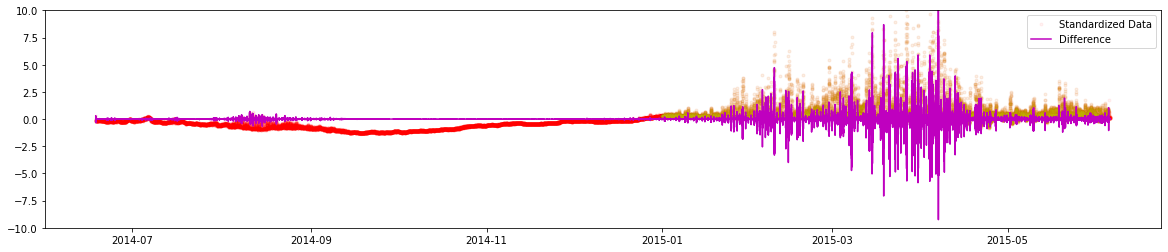

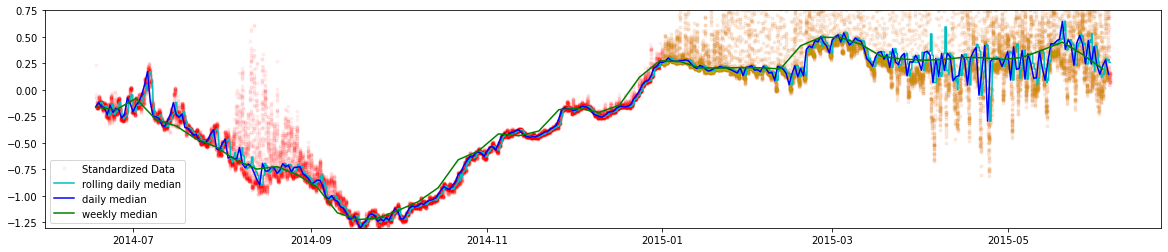

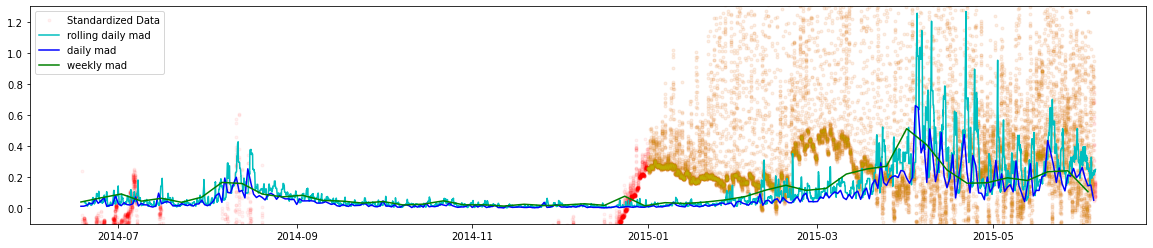

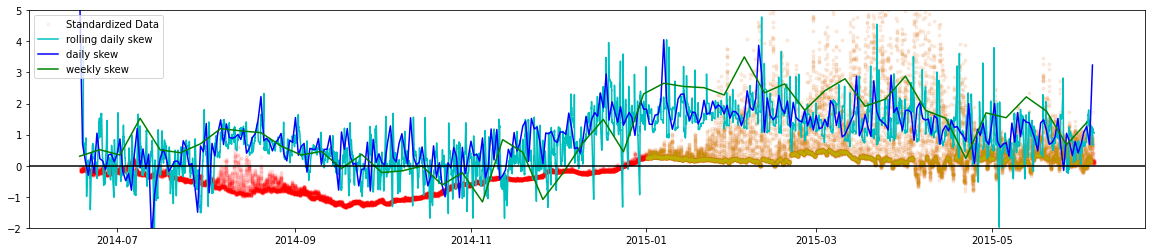

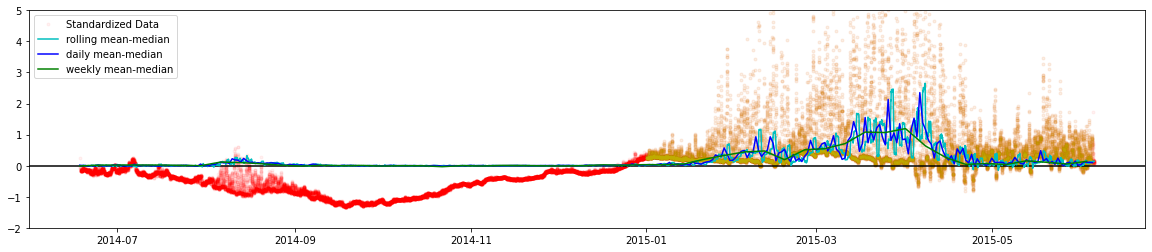

In [62]:
# Plot the rolling, daily, and weekly medians and mads and the difference all on one plot:

plt.rcParams["figure.figsize"] = (20,4)

plt.plot(ds1['time'], ds1['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds1['time'][mask1], ds1['standardized_o2_conc'][mask1], 'y.', alpha = 0.05)
plt.plot(ds1_diff['time'], ds1_diff['standardized_o2_conc'], 'm-', label='Difference')
plt.ylim(-10,10)
plt.legend()
plt.show()

plt.plot(ds1['time'], ds1['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds1['time'][mask1], ds1['standardized_o2_conc'][mask1], 'y.', alpha = 0.05)
plt.plot(ds1_rolling['time'], ds1_rolling['median'], 'c-', label='rolling daily median')
plt.plot(ds1_daily['time'], ds1_daily['median'], 'b-', label='daily median')
plt.plot(ds1_weekly['time'], ds1_weekly['median'], 'g-', label='weekly median')
plt.ylim(-1.3, 0.75)
plt.legend()
plt.show()

plt.plot(ds1['time'], ds1['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds1['time'][mask1], ds1['standardized_o2_conc'][mask1], 'y.', alpha = 0.05)
plt.plot(ds1_rolling['time'], ds1_rolling['mad'], 'c-', label='rolling daily mad')
plt.plot(ds1_daily['time'], ds1_daily['mad'], 'b-', label='daily mad')
plt.plot(ds1_weekly['time'], ds1_weekly['mad'], 'g-', label='weekly mad')
plt.ylim(-0.1, 1.3)
plt.legend()
plt.show()

plt.plot(ds1['time'], ds1['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds1['time'][mask1], ds1['standardized_o2_conc'][mask1], 'y.', alpha = 0.05)
plt.plot(ds1_rolling['time'], ds1_rolling['skew'], 'c-', label='rolling daily skew')
plt.plot(ds1_daily['time'], ds1_daily['skew'], 'b-', label='daily skew')
plt.plot(ds1_weekly['time'], ds1_weekly['skew'], 'g-', label='weekly skew')
plt.ylim(-2, 5)
plt.axhline(y=0, color='k')
plt.legend()
plt.show()

plt.plot(ds1['time'], ds1['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds1['time'][mask1], ds1['standardized_o2_conc'][mask1], 'y.', alpha = 0.05)
plt.axhline(y=0, color='k')
plt.plot(ds1_rolling['time'], ds1_rolling['mean-median'], 'c-', label='rolling mean-median')
plt.plot(ds1_daily['time'], ds1_daily['mean-median'], 'b-', label='daily mean-median')
plt.plot(ds1_weekly['time'], ds1_weekly['mean-median'], 'g-', label='weekly mean-median')
plt.ylim(-2, 5)
plt.legend()
plt.show()

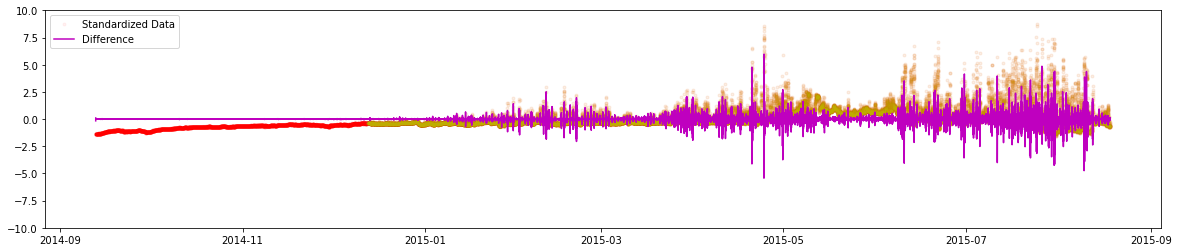

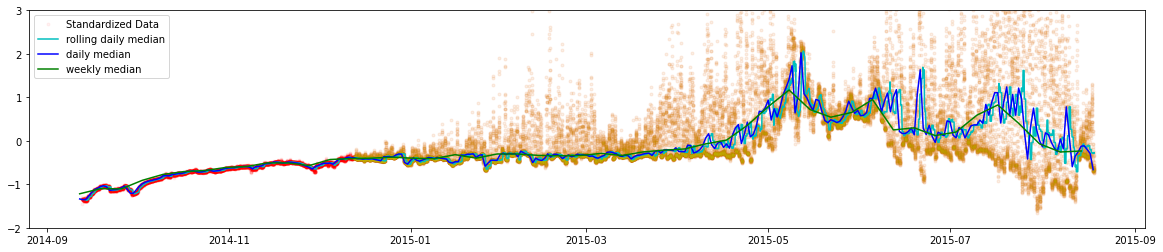

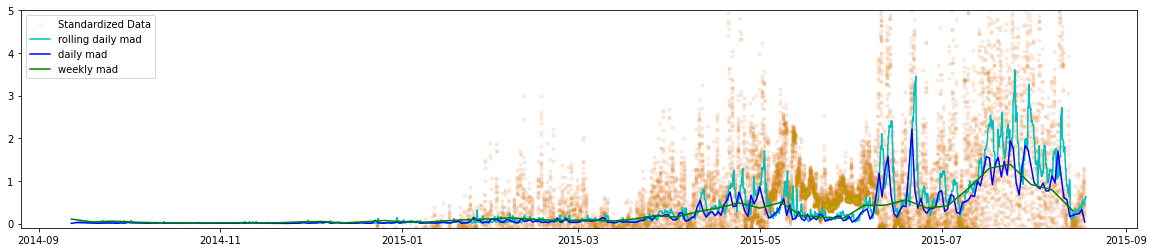

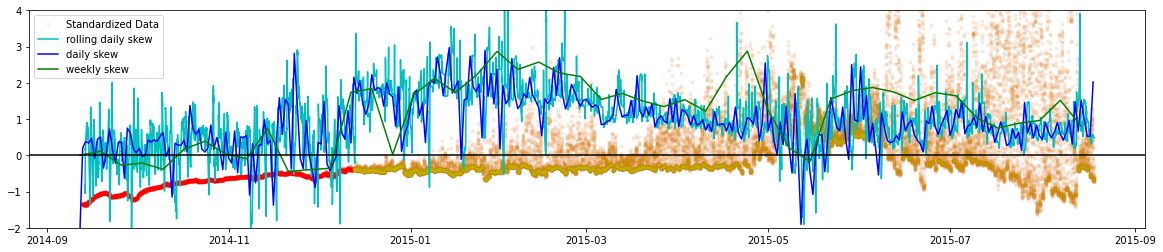

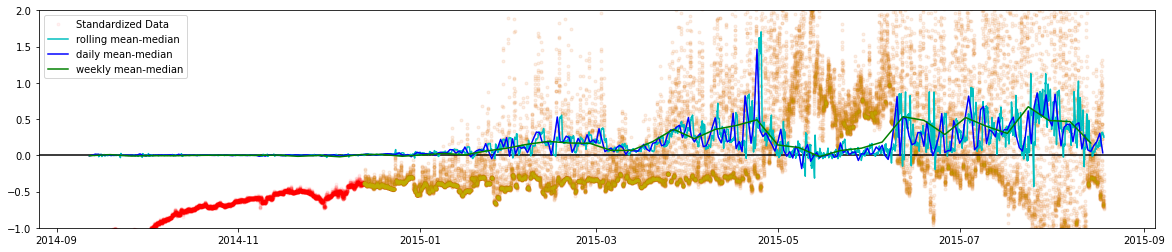

In [63]:
# Plot the rolling, daily, and weekly medians and mads and the difference all on one plot:

plt.rcParams["figure.figsize"] = (20,4)

plt.plot(ds2['time'], ds2['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds2['time'][mask2], ds2['standardized_o2_conc'][mask2], 'y.', alpha = 0.05)
plt.plot(ds2_diff['time'], ds2_diff['standardized_o2_conc'], 'm-', label='Difference')
plt.ylim(-10,10)
plt.legend()
plt.show()

plt.plot(ds2['time'], ds2['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds2['time'][mask2], ds2['standardized_o2_conc'][mask2], 'y.', alpha = 0.05)
plt.plot(ds2_rolling['time'], ds2_rolling['median'], 'c-', label='rolling daily median')
plt.plot(ds2_daily['time'], ds2_daily['median'], 'b-', label='daily median')
plt.plot(ds2_weekly['time'], ds2_weekly['median'], 'g-', label='weekly median')
plt.ylim(-2, 3)
plt.legend()
plt.show()

plt.plot(ds2['time'], ds2['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds2['time'][mask2], ds2['standardized_o2_conc'][mask2], 'y.', alpha = 0.05)
plt.plot(ds2_rolling['time'], ds2_rolling['mad'], 'c-', label='rolling daily mad')
plt.plot(ds2_daily['time'], ds2_daily['mad'], 'b-', label='daily mad')
plt.plot(ds2_weekly['time'], ds2_weekly['mad'], 'g-', label='weekly mad')
plt.ylim(-0.1, 5)
plt.legend()
plt.show()

plt.plot(ds2['time'], ds2['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds2['time'][mask2], ds2['standardized_o2_conc'][mask2], 'y.', alpha = 0.05)
plt.plot(ds2_rolling['time'], ds2_rolling['skew'], 'c-', label='rolling daily skew')
plt.plot(ds2_daily['time'], ds2_daily['skew'], 'b-', label='daily skew')
plt.plot(ds2_weekly['time'], ds2_weekly['skew'], 'g-', label='weekly skew')
plt.ylim(-2, 4)
plt.axhline(y=0, color='k')
plt.legend()
plt.show()

plt.plot(ds2['time'], ds2['standardized_o2_conc'], 'r.', alpha = 0.05, label='Standardized Data')
plt.plot(ds2['time'][mask2], ds2['standardized_o2_conc'][mask2], 'y.', alpha = 0.05)
plt.axhline(y=0, color='k')
plt.plot(ds2_rolling['time'], ds2_rolling['mean-median'], 'c-', label='rolling mean-median')
plt.plot(ds2_daily['time'], ds2_daily['mean-median'], 'b-', label='daily mean-median')
plt.plot(ds2_weekly['time'], ds2_weekly['mean-median'], 'g-', label='weekly mean-median')
plt.ylim(-1, 2)
plt.legend()
plt.show()

**SUMMARY:**

I'm not sure how statistically sound this is, but from the plots, it looks like the difference between the mean and the median shows the most distinct change when biofouling occurs compared to the other statistics tested.

Due to this distinction, I started looking at the skew of the data, as skew encompasses the relationship between the mean and the median.  However, the skew does not visually show as distinct a difference at the start of biofouling as does simply the difference between the mean and median.

SETTING A THRESHOLD:

* Can we set one threshold to determine biofouled data across all files?
    * We would expect different regions of ocean to have different distributions of oxygen based on multiple factors. One threshold for all data files becomes problematic for certain statistics (ie, we should not set a threshold for biofouled data by saying once the standard deviation goes above some set value, as this value may change for certain data files).
    
    * If we set a threshold based on skew or on the relationship between the mean and the median, can this threshold be used across datasets? 
    
MOVING FORWARD:
* Find a way to automate setting a threshold.